In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")#不显示警告信息

#参数初始化
discfile = 'arima_data.xls'
data = pd.read_excel(discfile, index_col = u'日期')

In [2]:
data.head()

,销量
日期,
2015-01-01,3023
2015-01-02,3039
2015-01-03,3056
2015-01-04,3138
2015-01-05,3188


In [3]:
#时序图
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
data.plot()
plt.show()

<Figure size 640x480 with 1 Axes>

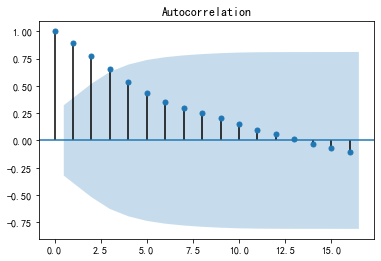

In [4]:
#自相关图
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data).show()

In [5]:
from statsmodels.tsa.stattools import adfuller as ADF
#u+字符串表示后面字符串以 Unicode格式 进行编码，一般用在中文字符串前面，防止因为源码储存格式问题，导致再次使用时出现乱码。
##返回值依次为adf、pvalue、usedlag、nobs、critical values、icbest、regresults、resstore
print(u'原始序列的ADF检验结果为：', ADF(data[u'销量'])) 

原始序列的ADF检验结果为： (1.813771015094526, 0.9983759421514264, 10, 26, {'1%': -3.7112123008648155, '5%': -2.981246804733728, '10%': -2.6300945562130176}, 299.4698986602418)


时序图显示该序列具有明显的单调递增趋势， 可以判断为是非平稳序列自相关图显示自相关系数长期大于零， 说明序列间具有很强的长期相关性；单位根检验统计量对应的p值显著大于0.05, 最终将该序列判断为非平稳序列

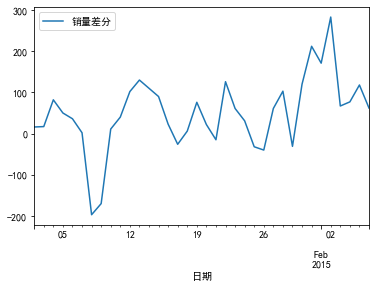

In [6]:
#一阶 差分
D_data = data.diff().dropna()
D_data.columns = [u'销量差分']
D_data.plot() #时序图
plt.show()

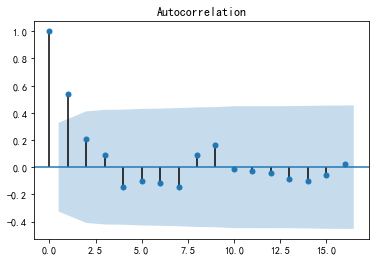

In [7]:
plot_acf(D_data).show() #自相关图

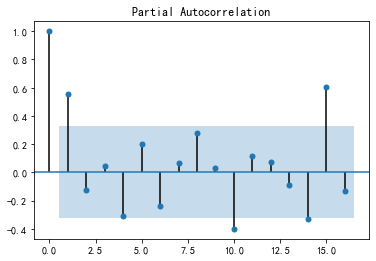

In [8]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(D_data).show() #偏自相关图

In [9]:
print(u'差分序列的ADF检验结果为：', ADF(D_data[u'销量差分'])) #平稳性检测

差分序列的ADF检验结果为： (-3.1560562366723537, 0.022673435440048798, 0, 35, {'1%': -3.6327426647230316, '5%': -2.9485102040816327, '10%': -2.6130173469387756}, 287.5909090780334)


In [10]:
#白噪声检验
from statsmodels.stats.diagnostic import acorr_ljungbox
print(u'差分序列的白噪声检验结果为：', acorr_ljungbox(D_data, lags=1)) #返回统计量和p值

差分序列的白噪声检验结果为： (array([11.30402222]), array([0.00077339]))


输出的p值远小于0.05, 所以一阶差分之后的序列是平稳非白噪声序列

In [11]:
from statsmodels.tsa.arima_model import ARIMA


data[u'销量'] = data[u'销量'].astype(float)
#定阶
pmax = int(len(D_data)/10) #一般阶数不超过length/10
qmax = int(len(D_data)/10) #一般阶数不超过length/10
bic_matrix = [] #bic矩阵
for p in range(pmax+1):
  tmp = []
  for q in range(qmax+1):
    try: #存在部分报错，所以用try来跳过报错。
      tmp.append(ARIMA(data, (p,1,q)).fit().bic)
    except:
      tmp.append(None)
  bic_matrix.append(tmp)

C:\Users\Smile\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Smile\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Smile\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Smile\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Smile\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Smile\

In [12]:
bic_matrix = pd.DataFrame(bic_matrix) #从中可以找出最小值
print(bic_matrix)

            0           1           2           3
0  432.068472  422.510082  426.088911  426.595507
1  423.628276  426.073601         NaN         NaN
2  426.774824  427.395856         NaN         NaN
3  430.317524  431.924894  434.761700  436.478109


In [13]:
p,q = bic_matrix.stack().idxmin() #先用stack展平，然后用idxmin找出最小值位置。
print(u'BIC最小的p值和q值为：%s、%s' %(p,q)) 

BIC最小的p值和q值为：0、1


In [14]:
model = ARIMA(data, (p,1,q)).fit() #建立ARIMA(0, 1, 1)模型

C:\Users\Smile\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Smile\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [15]:
model.summary2() #给出一份模型报告

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            BIC:                 422.5101  
Dependent Variable: D.销量             Log-Likelihood:      -205.88   
Date:               2021-01-03 16:36 Scale:               1.0000    
No. Observations:   36               Method:              css-mle   
Df Model:           2                Sample:              01-02-2015
Df Residuals:       34                                    02-06-2015
Converged:          1.0000           S.D. of innovations: 73.086    
No. Iterations:     15.0000          HQIC:                419.418   
AIC:                417.7595                                        
----------------------------------------------------------------------
               Coef.    Std.Err.     t      P>|t|     [0.025    0.975]
----------------------------------------------------------------------
const         49.9564    20.1390   2.4806   0.0182   10.4847   89.4281
ma.L1.D.销量     0.6710     0.1648   4.0712   0.0003    0.3480    0.9941
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
MA.1           -1.4902             0.0000           1.4902             0.5000
====================================================================

"""

In [16]:
model.forecast(5) #作为期5天的预测，返回预测结果、标准误差、置信区间。

(array([4873.9667493 , 4923.92317644, 4973.87960359, 5023.83603073,
        5073.79245787]),
 array([ 73.08574293, 142.32679918, 187.542821  , 223.80281869,
        254.95704265]),
 array([[4730.72132537, 5017.21217324],
        [4644.96777602, 5202.87857687],
        [4606.30242887, 5341.4567783 ],
        [4585.19056646, 5462.48149499],
        [4574.08583666, 5573.49907907]]))